In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_hdf("./dataframe.h5")

In [3]:
def dataloader_energies(df):
    X = np.array([seq_to_onehot(row['Sequence']) for ind, row in df.iterrows()])
    Energies = np.array([row['E_Min'] for ind, row in df.iterrows()])
    return X, Energies

def seq_to_onehot(seq,N_max=12):
    seq = seq.ljust(N_max)
    encoding = np.zeros((N_max,3))
    for i,S in enumerate(seq):
        if S=='A':
            encoding[i,0] = 1.
        elif S=='B':
            encoding[i,1] = 1.
        elif S==' ':
            encoding[i,2] = 1.
    return encoding.flatten()

In [4]:
X, Y = dataloader_energies(df)
print(X.shape, Y.shape)

(4216, 36) (4216,)


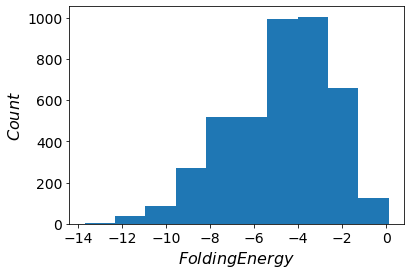

In [5]:
plt.hist(Y)
#formating
#plt.xlim([0.0,1.5])
#plt.ylim([0.0,2.0])
plt.xlabel('$Folding Energy$',fontsize=16)
plt.ylabel('$Count$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

#plt.savefig('tinyfold_energy_histogram.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)
plt.show()

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import copy
import time

In [7]:
tensor_x = torch.Tensor(X) # transform to torch tensor
tensor_y = torch.Tensor(Y)



my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
training_set, validation_set, test_set = torch.utils.data.random_split(my_dataset,[3000,256,960])
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True) # create your dataloader
valid_dataloader = DataLoader(validation_set, batch_size=256, shuffle=True) # create your dataloader
test_dataloader = DataLoader(test_set, batch_size=960, shuffle=True) # create your dataloader

In [8]:
def train(training_set,validation_set,
          max_epochs=200,layer_size=64,n_hidden=2,
          Dropout=False,p_Drop=0.5,BatchNorm=False,
          batch_size=64,learning_rate=0.005,optimizer='Adam',weight_decay=0,
          Verbose=False):
    #Training Loop
    train_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True) # create your dataloader
    valid_dataloader = DataLoader(validation_set, batch_size=256, shuffle=True) # create your dataloader

    model = NN_Regressor(layer_size=layer_size,n_hidden=n_hidden,Dropout=Dropout,p_Drop=p_Drop,BatchNorm=BatchNorm)
    
    # Define Optimizer and Loss Function
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    loss_func = torch.nn.MSELoss()
    
    #n_epochs = 151
    if Verbose:
        print(f'{"Epoch".ljust(7)} {"Training Loss".ljust(20)} {"Validation Loss".ljust(20)} {"Time".ljust(20)}')

    val_lowest = 10*8 
    epochs = []
    val_losses = []
    train_losses = []
    parameters = []
    timings = []
    
    for epoch in range(max_epochs+1):
        t0 = time.time()
        train_loss = []
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            train_loss.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
        train_loss = np.mean(np.array(train_loss))
        for i, data in enumerate(valid_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
        t1 = time.time() - t0
        if epoch%10 == 0:
            best = ' '
            if loss < val_lowest:
                best_model = copy.deepcopy(model)
                val_lowest=float(loss)
                #print('best model',epoch)
                best = '*'
            epochs.append(epoch)
            #parameters.append(model.linear1.weight.data)
            val_losses.append(float(loss.detach().numpy()))  
            train_losses.append(float(train_loss)) 
            timings.append(t1)
            train_loss = str(round(float(train_loss),4)).ljust(20)
            valid_loss = str(round(float(loss.detach().numpy()),4)).ljust(20)
            timing = str(round(t1,3)).ljust(20)
            i_epoch    = str(epoch).ljust(7)  
            if Verbose:
                print(f'{i_epoch} {train_loss} {valid_loss} {timing} {best}')
    results = {'val_best':val_lowest,'val_losses':val_losses,'train_losses':train_losses,'timings':timings,'epochs':epochs}
    return best_model, results

In [9]:
class NN_Regressor(nn.Module):
    def __init__(self,layer_size=64,n_hidden=2,Dropout=False,p_Drop=0.5,BatchNorm=False):
        super(NN_Regressor, self).__init__()
        modules = [nn.Linear(36, layer_size),nn.ReLU()]
        if Dropout==True:
                modules.append(nn.Dropout(p=0.1))
        for i in range(n_hidden-1):
            modules.append(nn.Linear(layer_size, layer_size))
            if BatchNorm==True:
                modules.append(nn.BatchNorm1d(layer_size))
            modules.append(nn.ReLU())
            if Dropout==True:
                modules.append(nn.Dropout(p=p_Drop))

        modules.append(nn.Linear(layer_size, 1))
        self.mlp = nn.Sequential(*modules)

    def forward(self, x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        return torch.squeeze(self.mlp(x))

model = NN_Regressor(layer_size=64,n_hidden=2)
print(model)

NN_Regressor(
  (mlp): Sequential(
    (0): Linear(in_features=36, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [48]:
model_lr01, results_lr01 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=32,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       2.4706               0.3248               0.306                *
10      0.068                0.1011               0.342                *
20      0.0801               0.0908               0.369                *
30      0.0454               0.0461               0.349                *
40      0.0417               0.0836               0.341                 
50      0.0365               0.0402               0.346                *
60      0.0362               0.0427               0.351                 
70      0.0346               0.0371               0.403                *
80      0.0245               0.0442               0.435                 
90      0.0262               0.0677               0.373                 
100     0.0295               0.0449               0.348                 
110     0.0187               0.0364               0.338                *
120     0.0174               0.0585               0.3

In [49]:
plt.plot(results_lr01['epochs'],results_lr01['train_losses'],label="Training Set")
plt.plot(results_lr01['epochs'],results_lr01['val_losses'],label="Validation Set")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_lr_0.01.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [50]:
model_lr005, results_lr005 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.005,batch_size=32,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       3.0477               0.2984               0.507                *
10      0.0712               0.0692               0.373                *
20      0.0571               0.0574               0.357                *
30      0.046                0.1122               0.414                 
40      0.0283               0.0361               0.353                *
50      0.0306               0.0294               0.391                *
60      0.029                0.0383               0.34                  
70      0.0291               0.0301               0.345                 
80      0.0254               0.03                 0.4                   
90      0.0189               0.0283               0.335                *
100     0.0252               0.0281               0.36                 *
110     0.0189               0.0296               0.343                 
120     0.0309               0.0249               0.3

In [51]:
plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="Validation Set")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_lr_0.005.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [53]:
model_lr001, results_lr001 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.001,batch_size=32,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       9.8562               1.6294               0.136                *
10      0.1179               0.1374               0.343                *
20      0.0508               0.0723               0.351                *
30      0.0406               0.0551               0.342                *
40      0.0337               0.0401               0.384                *
50      0.0286               0.0379               0.404                *
60      0.0258               0.0445               0.326                 
70      0.0243               0.0485               0.385                 
80      0.0211               0.0305               0.327                *
90      0.0192               0.0317               0.318                 
100     0.0168               0.0294               0.316                *
110     0.0177               0.0296               0.334                 
120     0.015                0.0302               0.3

In [54]:
model_lr0001, results_lr0001 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.0001,batch_size=32,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       26.1892              23.2554              0.358                *
10      0.4357               0.3761               0.318                *
20      0.3014               0.2905               0.305                *
30      0.2496               0.2484               0.318                *
40      0.1965               0.2145               0.336                *
50      0.1541               0.174                0.323                *
60      0.1298               0.1529               0.325                *
70      0.1134               0.1356               0.334                *
80      0.1004               0.1231               0.339                *
90      0.0898               0.1119               0.352                *
100     0.0794               0.1048               0.341                *
110     0.0714               0.0906               0.334                *
120     0.0644               0.0867               0.3

In [56]:
model_lr08, results_lr08 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.08,batch_size=32,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       4.9405               0.3499               0.369                *
10      0.2469               0.4703               0.347                 
20      0.2886               0.3429               0.349                *
30      0.2038               0.2063               0.351                *
40      0.2004               0.2223               0.357                 
50      0.239                0.215                0.364                 
60      0.2426               0.2319               0.361                 
70      0.224                0.2419               0.348                 
80      0.2491               0.2462               0.349                 
90      0.248                0.24                 0.353                 
100     0.2443               0.2727               0.405                 
110     0.2265               0.5462               0.362                 
120     0.2809               0.3162               0.3

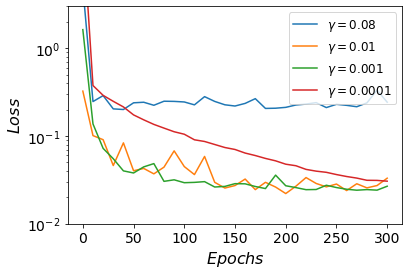

In [154]:
plt.plot(results_lr08['epochs'],results_lr08['train_losses'],label="$\gamma=0.08$")
plt.plot(results_lr01['epochs'],results_lr01['val_losses'],label="$\gamma=0.01$")
#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
plt.plot(results_lr001['epochs'],results_lr001['val_losses'],label="$\gamma=0.001$")
plt.plot(results_lr0001['epochs'],results_lr0001['val_losses'],label="$\gamma=0.0001$")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_val_lrs.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

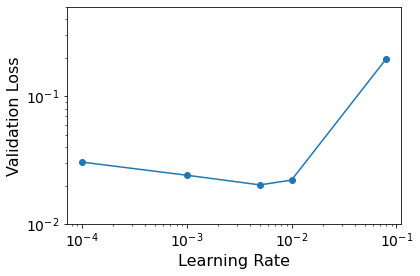

In [61]:
#plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot([0.08,0.01,0.005,0.001,0.0001],[results_lr08['val_best'],results_lr01['val_best'],results_lr005['val_best'],results_lr001['val_best'],results_lr0001['val_best']])
plt.scatter([0.08,0.01,0.005,0.001,0.0001],[results_lr08['val_best'],results_lr01['val_best'],results_lr005['val_best'],results_lr001['val_best'],results_lr0001['val_best']])

#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
#plt.plot(results_batch32['epochs'],results_batch32['val_losses'],label="Batch Size = 32")
#plt.plot(results_batch64['epochs'],results_batch64['val_losses'],label="Batch Size = 64")

#formating
plt.ylim([1e-2,0.5])
plt.yscale('log')

plt.xscale('log')
plt.xlabel('Learning Rate',fontsize=16)
plt.ylabel('Validation Loss',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('val_loss_vs_lr.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [28]:
model_batch16, results_batch16 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.001,batch_size=16,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       4.9321               0.3174               0.137                *
10      0.0838               0.0966               0.212                *
20      0.0394               0.0533               0.565                *
30      0.0268               0.0421               0.605                *
40      0.0221               0.0319               0.565                *
50      0.019                0.029                0.557                *
60      0.0171               0.0255               0.555                *
70      0.0159               0.0257               0.556                 
80      0.0163               0.0295               0.563                 
90      0.0145               0.0269               0.565                 
100     0.0156               0.0226               0.452                *
110     0.0124               0.0226               0.51                  
120     0.0133               0.0294               0.5

In [29]:
model_batch32, results_batch32 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.001,batch_size=32,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       11.5131              1.7007               0.116                *
10      0.1401               0.1655               0.32                 *
20      0.0764               0.086                0.36                 *
30      0.0465               0.0578               0.346                *
40      0.0363               0.0444               0.364                *
50      0.0244               0.0421               0.335                *
60      0.0236               0.037                0.334                *
70      0.0201               0.0425               0.349                 
80      0.0178               0.028                0.336                *
90      0.0165               0.0284               0.368                 
100     0.0168               0.0289               0.406                 
110     0.0152               0.0252               0.388                *
120     0.0137               0.0274               0.3

In [30]:
model_batch64, results_batch64 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.001,batch_size=64,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       18.2146              5.2983               0.076                *
10      0.1867               0.2026               0.062                *
20      0.0966               0.1114               0.204                *
30      0.0673               0.0892               0.198                *
40      0.0501               0.0526               0.215                *
50      0.0387               0.049                0.196                *
60      0.0323               0.0431               0.193                *
70      0.0281               0.0376               0.19                 *
80      0.0252               0.032                0.199                *
90      0.0235               0.0302               0.201                *
100     0.0217               0.0301               0.202                *
110     0.0192               0.0252               0.197                *
120     0.0188               0.0258               0.1

In [33]:
model_batch128, results_batch128 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.001,batch_size=128,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       23.8767              16.7172              0.042                *
10      0.2891               0.2725               0.045                *
20      0.1757               0.1798               0.093                *
30      0.1241               0.1378               0.131                *
40      0.1023               0.1135               0.149                *
50      0.0777               0.0913               0.16                 *
60      0.0596               0.0691               0.137                *
70      0.0491               0.0589               0.132                *
80      0.0425               0.0503               0.132                *
90      0.0347               0.0461               0.148                *
100     0.0313               0.0427               0.169                *
110     0.0292               0.0413               0.157                *
120     0.0267               0.0397               0.1

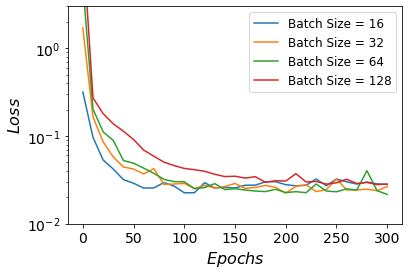

In [153]:
#plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot(results_batch16['epochs'],results_batch16['val_losses'],label="Batch Size = 16")
#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
plt.plot(results_batch32['epochs'],results_batch32['val_losses'],label="Batch Size = 32")
plt.plot(results_batch64['epochs'],results_batch64['val_losses'],label="Batch Size = 64")
plt.plot(results_batch128['epochs'],results_batch128['val_losses'],label="Batch Size = 128")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_val_batch_size.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [45]:
#plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot([16,32,64,128],[results_batch16['val_best'],results_batch32['val_best'],results_batch64['val_best'],results_batch128['val_best']])
plt.scatter([16,32,64,128],[results_batch16['val_best'],results_batch32['val_best'],results_batch64['val_best'],results_batch128['val_best']])

#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
#plt.plot(results_batch32['epochs'],results_batch32['val_losses'],label="Batch Size = 32")
#plt.plot(results_batch64['epochs'],results_batch64['val_losses'],label="Batch Size = 64")

#formating
#plt.ylim([1e-2,3])
#plt.yscale('log')
plt.xlabel('Batch Size',fontsize=16)
plt.ylabel('Validation Loss',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('val_loss_vs_batch_size.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

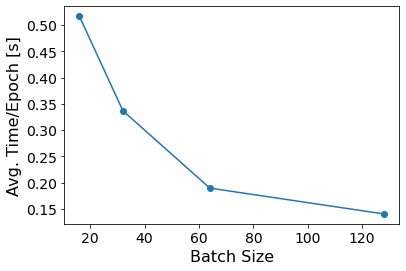

In [46]:
#plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot([16,32,64,128],[np.mean(results_batch16['timings']),np.mean(results_batch32['timings']),np.mean(results_batch64['timings']),np.mean(results_batch128['timings'])])
plt.scatter([16,32,64,128],[np.mean(results_batch16['timings']),np.mean(results_batch32['timings']),np.mean(results_batch64['timings']),np.mean(results_batch128['timings'])])

#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
#plt.plot(results_batch32['epochs'],results_batch32['val_losses'],label="Batch Size = 32")
#plt.plot(results_batch64['epochs'],results_batch64['val_losses'],label="Batch Size = 64")

#formating
#plt.ylim([1e-2,3])
#plt.yscale('log')
plt.ylabel('Avg. Time/Epoch [s]',fontsize=16)
plt.xlabel('Batch Size',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('timings_batch_size.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [63]:
model_1, results_1 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_2, results_2 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_3, results_3 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_4, results_4 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_5, results_5 = train(training_set,validation_set,
                           max_epochs=300,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       3.4349               0.3083               0.078                *
10      0.0921               0.0885               0.082                *
20      0.0454               0.0525               0.247                *
30      0.0469               0.0556               0.201                 
40      0.0363               0.074                0.192                 
50      0.0348               0.0449               0.198                *
60      0.032                0.0314               0.203                *
70      0.0274               0.0353               0.2                   
80      0.045                0.0382               0.216                 
90      0.0207               0.0309               0.207                *
100     0.0329               0.0367               0.207                 
110     0.0212               0.0295               0.208                *
120     0.023                0.0303               0.2

In [65]:
plt.plot(results_1['epochs'],results_1['val_losses'],label="Model 1")
plt.plot(results_2['epochs'],results_2['val_losses'],label="Model 2")
plt.plot(results_3['epochs'],results_3['val_losses'],label="Model 3")
plt.plot(results_4['epochs'],results_4['val_losses'],label="Model 4")
plt.plot(results_5['epochs'],results_5['val_losses'],label="Model 5")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_val_models.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

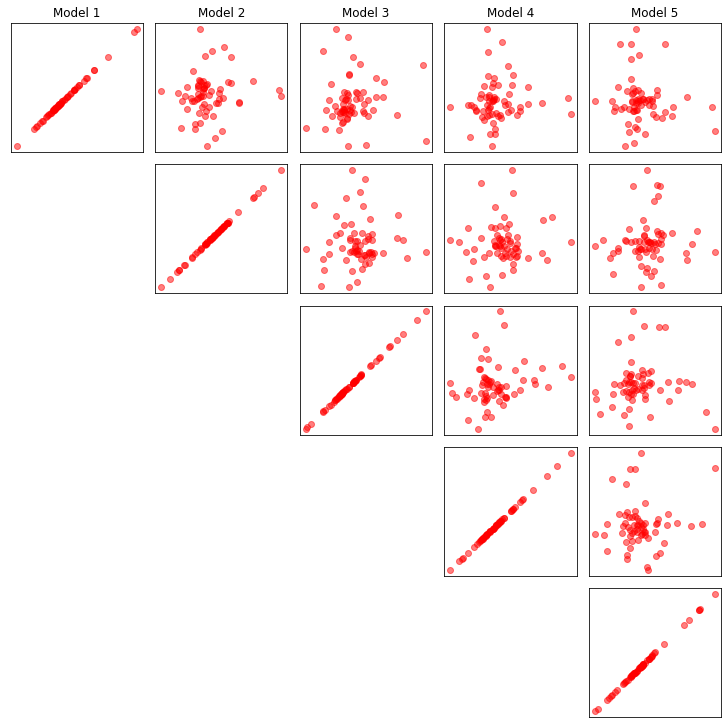

In [127]:
#model_1.named_parameters()['mlp.4.weight'].data

for name, param in model_1.named_parameters():
    if name == 'mlp.4.weight' :
        #print(name, param.data) 
        w1 = param.data.detach().numpy()
        
for name, param in model_2.named_parameters():
    if name == 'mlp.4.weight' :
        #print(name, param.data) 
        w2 = param.data.detach().numpy()
        
for name, param in model_3.named_parameters():
    if name == 'mlp.4.weight' :
        #print(name, param.data) 
        w3 = param.data.detach().numpy()

for name, param in model_4.named_parameters():
    if name == 'mlp.4.weight' :
        #print(name, param.data) 
        w4 = param.data.detach().numpy()

for name, param in model_5.named_parameters():
    if name == 'mlp.4.weight' :
        #print(name, param.data) 
        w5 = param.data.detach().numpy()
        
#plt.scatter(w1,w2)
#plt.scatter(w1,w3)
#plt.scatter(w1,w4)
#plt.scatter(w1,w5)

fig = plt.figure(constrained_layout=True,frameon=False,figsize=(10,10))

ax_dict = fig.subplot_mosaic(
    [
        ["w1 w1", "w1 w2", "w1 w3", "w1 w4", "w1 w5"],
        ["w2 w1", "w2 w2", "w2 w3", "w2 w4", "w2 w5"],
        ["w3 w1", "w3 w2", "w3 w3", "w3 w4", "w3 w5"],
        ["w4 w1", "w4 w2", "w4 w3", "w4 w4", "w4 w5"],
        ["w5 w1", "w5 w2", "w5 w3", "w5 w4", "w5 w5"]
    ],
)

upper_keys = ["w1 w1", "w1 w2", "w1 w3", "w1 w4", "w1 w5", "w2 w2", "w2 w3", "w2 w4", "w2 w5", "w3 w3", "w3 w4", "w3 w5", "w4 w4", "w4 w5", "w5 w5"]

ax_dict["w1 w1"].scatter(w1,w1,c='r',alpha=0.5)
ax_dict["w1 w1"].set_title('Model 1')
ax_dict["w1 w2"].scatter(w1,w2,c='r',alpha=0.5)
ax_dict["w1 w2"].set_title('Model 2')
ax_dict["w1 w3"].scatter(w1,w3,c='r',alpha=0.5)
ax_dict["w1 w3"].set_title('Model 3')
ax_dict["w1 w4"].scatter(w1,w4,c='r',alpha=0.5)
ax_dict["w1 w4"].set_title('Model 4')
ax_dict["w1 w5"].scatter(w1,w5,c='r',alpha=0.5)
ax_dict["w1 w5"].set_title('Model 5')
ax_dict["w2 w2"].scatter(w2,w2,c='r',alpha=0.5)
ax_dict["w2 w3"].scatter(w2,w3,c='r',alpha=0.5)
ax_dict["w2 w4"].scatter(w2,w4,c='r',alpha=0.5)
ax_dict["w2 w5"].scatter(w2,w5,c='r',alpha=0.5)
ax_dict["w3 w3"].scatter(w3,w3,c='r',alpha=0.5)
ax_dict["w3 w4"].scatter(w3,w4,c='r',alpha=0.5)
ax_dict["w3 w5"].scatter(w3,w5,c='r',alpha=0.5)
ax_dict["w4 w4"].scatter(w4,w4,c='r',alpha=0.5)
ax_dict["w4 w5"].scatter(w4,w5,c='r',alpha=0.5)
ax_dict["w5 w5"].scatter(w5,w5,c='r',alpha=0.5)

for key in ax_dict.keys():
    ax_dict[key].get_xaxis().set_ticks([])
    ax_dict[key].get_yaxis().set_ticks([])
    if key not in upper_keys:
        ax_dict[key].axis('off')
    #ax_dict[key].set_title(key)
    #ax_dict[key].set_aspect('equal')

plt.savefig('model_parameter_correlations.png',bbox_inches='tight')
plt.show()


In [66]:
model_lay1, results_lay1 = train(training_set,validation_set,
                           max_epochs=400,layer_size=64,n_hidden=1,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_lay2, results_lay2 = train(training_set,validation_set,
                           max_epochs=400,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_lay3, results_lay3 = train(training_set,validation_set,
                           max_epochs=400,layer_size=64,n_hidden=3,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_lay4, results_lay4 = train(training_set,validation_set,
                           max_epochs=400,layer_size=64,n_hidden=4,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_lay5, results_lay5 = train(training_set,validation_set,
                           max_epochs=400,layer_size=64,n_hidden=5,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       5.0568               0.4151               0.055                *
10      0.1529               0.1407               0.043                *
20      0.0999               0.0939               0.045                *
30      0.0888               0.1                  0.044                 
40      0.0683               0.0893               0.049                *
50      0.0589               0.0714               0.097                *
60      0.0583               0.0685               0.177                *
70      0.048                0.0607               0.165                *
80      0.0508               0.0593               0.178                *
90      0.0413               0.0593               0.176                *
100     0.0422               0.0532               0.175                *
110     0.042                0.0526               0.18                 *
120     0.0399               0.0675               0.1

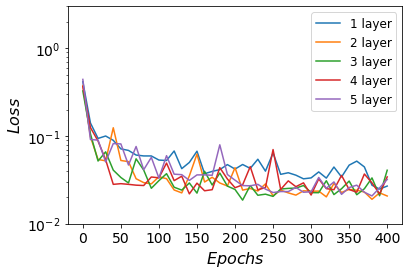

In [67]:
plt.plot(results_lay1['epochs'],results_lay1['val_losses'],label="1 layer")
plt.plot(results_lay2['epochs'],results_lay2['val_losses'],label="2 layer")
plt.plot(results_lay3['epochs'],results_lay3['val_losses'],label="3 layer")
plt.plot(results_lay4['epochs'],results_lay4['val_losses'],label="4 layer")
plt.plot(results_lay5['epochs'],results_lay5['val_losses'],label="5 layer")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_val_n_layers.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

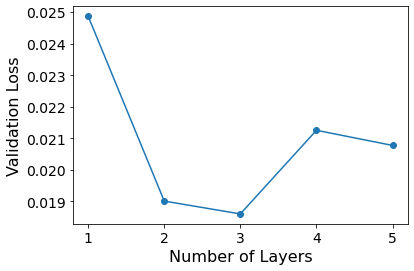

In [156]:
#plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot([1,2,3,4,5],[results_lay1['val_best'],results_lay2['val_best'],results_lay3['val_best'],results_lay4['val_best'],results_lay5['val_best']])
plt.scatter([1,2,3,4,5],[results_lay1['val_best'],results_lay2['val_best'],results_lay3['val_best'],results_lay4['val_best'],results_lay5['val_best']])

#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
#plt.plot(results_batch32['epochs'],results_batch32['val_losses'],label="Batch Size = 32")
#plt.plot(results_batch64['epochs'],results_batch64['val_losses'],label="Batch Size = 64")

#formating
#plt.ylim([1e-2,3])
#plt.yscale('log')
plt.xlabel('Number of Layers',fontsize=16)
plt.ylabel('Validation Loss',fontsize=16)
plt.xticks([1,2,3,4,5],fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('val_loss_vs_n_layers.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [162]:
model_nodes16, results_nodes16 = train(training_set,validation_set,
                           max_epochs=400,layer_size=16,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_nodes32, results_nodes32 = train(training_set,validation_set,
                           max_epochs=400,layer_size=32,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_nodes64, results_nodes64 = train(training_set,validation_set,
                           max_epochs=400,layer_size=64,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_nodes128, results_nodes128 = train(training_set,validation_set,
                           max_epochs=400,layer_size=128,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_nodes256, results_nodes256 = train(training_set,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       7.5973               0.9211               0.22                 *
10      0.2373               0.2417               0.196                *
20      0.1464               0.1547               0.209                *
30      0.1133               0.1538               0.206                *
40      0.0983               0.1091               0.196                *
50      0.0851               0.1026               0.191                *
60      0.0757               0.0934               0.201                *
70      0.0755               0.0792               0.197                *
80      0.061                0.0835               0.196                 
90      0.0566               0.071                0.192                *
100     0.0512               0.0668               0.206                *
110     0.0526               0.051                0.201                *
120     0.0471               0.0532               0.1

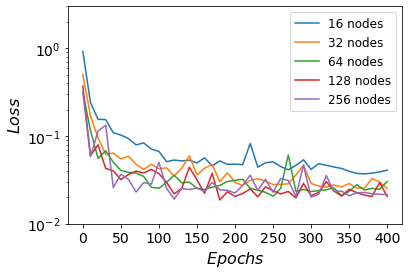

In [163]:
plt.plot(results_nodes16['epochs'],results_nodes16['val_losses'],label="16 nodes")
plt.plot(results_nodes32['epochs'],results_nodes32['val_losses'],label="32 nodes")
plt.plot(results_nodes64['epochs'],results_nodes64['val_losses'],label="64 nodes")
plt.plot(results_nodes128['epochs'],results_nodes128['val_losses'],label="128 nodes")
plt.plot(results_nodes256['epochs'],results_nodes256['val_losses'],label="256 nodes")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_val_n_nodes.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

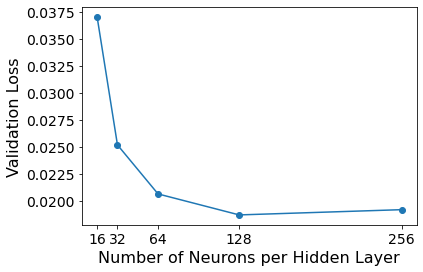

In [164]:
#plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot([16,32,64,128,256],[results_nodes16['val_best'],results_nodes32['val_best'],results_nodes64['val_best'],results_nodes128['val_best'],results_nodes256['val_best']])
plt.scatter([16,32,64,128,256],[results_nodes16['val_best'],results_nodes32['val_best'],results_nodes64['val_best'],results_nodes128['val_best'],results_nodes256['val_best']])

#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
#plt.plot(results_batch32['epochs'],results_batch32['val_losses'],label="Batch Size = 32")
#plt.plot(results_batch64['epochs'],results_batch64['val_losses'],label="Batch Size = 64")

#formating
#plt.ylim([1e-2,3])
#plt.yscale('log')
plt.xlabel('Number of Neurons per Hidden Layer',fontsize=16)
plt.ylabel('Validation Loss',fontsize=16)
plt.xticks([16,32,64,128,256],fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('val_loss_vs_n_nodes.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [71]:
for i, data in enumerate(test_dataloader):
    inputs, labels = data
    outputs = model_nodes256(inputs)
    ref_out = labels.detach().numpy()
    nn_out =  outputs.detach().numpy()

In [73]:
MAE  = np.mean(np.abs(nn_out-ref_out))
RMSE = np.sqrt(np.mean((nn_out-ref_out)**2))
print(MAE,RMSE)

0.09584381 0.12643144


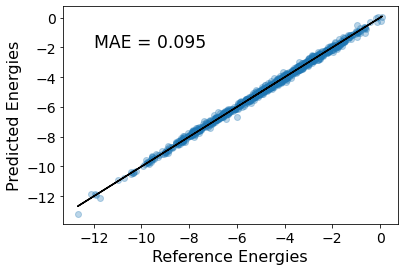

In [75]:
plt.scatter(ref_out,nn_out,alpha=0.3)
plt.plot(ref_out,ref_out,c='k')
plt.text(-12,-2,f'MAE = 0.095',fontsize='xx-large')

#formating
#plt.xlim([0.0,1.5])
#plt.yscale('log')
plt.xlabel('Reference Energies',fontsize=16)
plt.ylabel('Predicted Energies',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('test_correlation_plot_opt.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [10]:
# More data splits:
training_set1500, training_set1000, training_set500 = torch.utils.data.random_split(training_set,[1500,1000,500])
training_set100, training_set250, training_setrest = torch.utils.data.random_split(training_set,[100,250,3000-100-250])


In [11]:
model_3000, results_3000 = train(training_set,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_1500, results_1500 = train(training_set1500,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_1000, results_1000 = train(training_set1000,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_500, results_500   = train(training_set500,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_250, results_250   = train(training_set250,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)
model_100, results_100   = train(training_set100,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       1.9458               0.2876               3.096                *
10      0.0461               0.0586               0.068                *
20      0.0318               0.0274               0.256                *
30      0.0638               0.0603               0.319                 
40      0.0465               0.1033               0.34                  
50      0.021                0.0334               0.35                  
60      0.0142               0.0221               0.335                *
70      0.0182               0.0381               0.321                 
80      0.0159               0.024                0.326                 
90      0.0145               0.0203               0.343                *
100     0.019                0.023                0.329                 
110     0.0117               0.0253               0.324                 
120     0.0126               0.0366               0.3

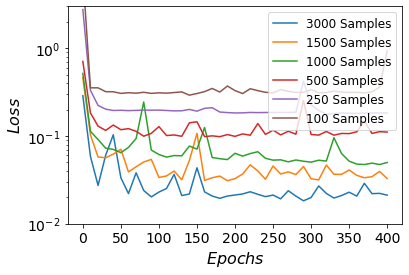

In [12]:
plt.plot(results_3000['epochs'],results_3000['val_losses'],label="3000 Samples")
plt.plot(results_1500['epochs'],results_1500['val_losses'],label="1500 Samples")
plt.plot(results_1000['epochs'],results_1000['val_losses'],label="1000 Samples")
plt.plot(results_500['epochs'],results_500['val_losses'],label="500 Samples")
plt.plot(results_250['epochs'],results_250['val_losses'],label="250 Samples")
plt.plot(results_100['epochs'],results_100['val_losses'],label="100 Samples")
#plt.plot(results_nodes256['epochs'],results_nodes256['val_losses'],label="256 nodes")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_val_n_train.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [13]:
for i, data in enumerate(test_dataloader):
    inputs, labels = data
    outputs_3000 = model_3000(inputs)
    ref_out = labels.detach().numpy()
    nn_out_3000 =  outputs_3000.detach().numpy()
    outputs_1500 = model_1500(inputs)
    ref_out = labels.detach().numpy()
    nn_out_1500 =  outputs_1500.detach().numpy()
    outputs_1000 = model_1000(inputs)
    ref_out = labels.detach().numpy()
    nn_out_1000 =  outputs_1000.detach().numpy()
    outputs_500 = model_500(inputs)
    ref_out = labels.detach().numpy()
    nn_out_500 =  outputs_500.detach().numpy()
    outputs_250 = model_250(inputs)
    ref_out = labels.detach().numpy()
    nn_out_250 =  outputs_250.detach().numpy()
    outputs_100 = model_100(inputs)
    ref_out = labels.detach().numpy()
    nn_out_100 =  outputs_100.detach().numpy()

In [14]:
MAE_3000  = np.mean(np.abs(nn_out_3000-ref_out))
RMSE_3000 = np.sqrt(np.mean((nn_out_3000-ref_out)**2))
MAE_1500  = np.mean(np.abs(nn_out_1500-ref_out))
RMSE_1500 = np.sqrt(np.mean((nn_out_1500-ref_out)**2))
MAE_1000  = np.mean(np.abs(nn_out_1000-ref_out))
RMSE_1000 = np.sqrt(np.mean((nn_out_1000-ref_out)**2))
MAE_500  = np.mean(np.abs(nn_out_500-ref_out))
RMSE_500 = np.sqrt(np.mean((nn_out_500-ref_out)**2))
MAE_250  = np.mean(np.abs(nn_out_250-ref_out))
RMSE_250 = np.sqrt(np.mean((nn_out_250-ref_out)**2))
MAE_100  = np.mean(np.abs(nn_out_100-ref_out))
RMSE_100 = np.sqrt(np.mean((nn_out_100-ref_out)**2))
#print(MAE,RMSE)

[0.48231876 0.3315356  0.2567679  0.17163372 0.1457538  0.10554029]


[]

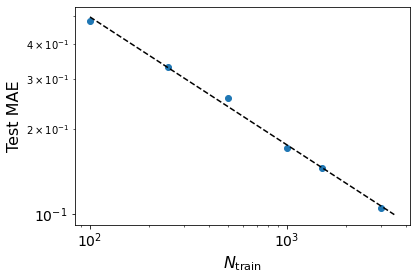

In [16]:
train_sizes = np.array([100,250,500,1000,1500,3000])
MAEs = np.array([MAE_100,MAE_250,MAE_500,MAE_1000,MAE_1500,MAE_3000])
print(MAEs)

plt.scatter(train_sizes,MAEs)

from scipy.stats import linregress 
fitresults = linregress(np.log2(train_sizes),np.log2(MAEs))
nspace = np.linspace(100,3500,100)

plt.plot(nspace,nspace**fitresults.slope*2**fitresults.intercept,c='k',linestyle='--')

#plt.plot([500,1000,1500,3000],[MAE_500,MAE_1000,MAE_1500,MAE_3000])

#formating
#plt.ylim([1e-2,3])
plt.xscale('log',base=10)
plt.yscale('log',base=10)

plt.xlabel('$N_\mathrm{train}$',fontsize=16)
plt.ylabel('Test MAE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('learning_curve_test_vs_ntrain.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.plot()

In [100]:
print(MAE_500)

0.25585216


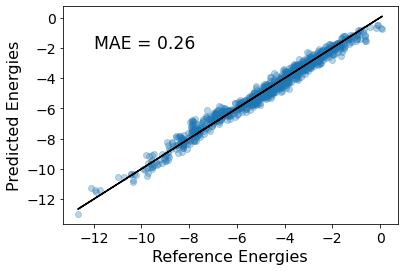

In [101]:
plt.scatter(ref_out,nn_out_500,alpha=0.3)
plt.plot(ref_out,ref_out,c='k')
plt.text(-12,-2,f'MAE = 0.26',fontsize='xx-large')

#formating
#plt.xlim([0.0,1.5])
#plt.yscale('log')
plt.xlabel('Reference Energies',fontsize=16)
plt.ylabel('Predicted Energies',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('test_correlation_plot_opt_500.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [131]:
model_unreg, results_unreg = train(training_set,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.5,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

model_Drop01, results_Drop01 = train(training_set,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=True,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

model_Drop02, results_Drop02 = train(training_set,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=True,p_Drop=0.2,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

model_Drop03, results_Drop03 = train(training_set,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=True,p_Drop=0.3,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       1.9955               0.257                0.164                *
10      0.0578               0.0499               0.264                *
20      0.0301               0.0403               0.352                *
30      0.0269               0.0498               0.357                 
40      0.0508               0.0403               0.354                *
50      0.0594               0.0382               0.355                *
60      0.0167               0.0356               0.364                *
70      0.0301               0.0519               0.367                 
80      0.0294               0.0237               0.356                *
90      0.0089               0.0222               0.384                *
100     0.0441               0.0227               0.351                 
110     0.0103               0.0225               0.35                  
120     0.0151               0.0276               0.3

In [141]:
model_wd0, results_wd0 = train(training_set500,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,weight_decay=1e-6,
                           Verbose=True)
model_wd1e6, results_wd1e6 = train(training_set500,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,weight_decay=1e-6,
                           Verbose=True)
model_wd1e4, results_wd1e4 = train(training_set500,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,weight_decay=1e-4,
                           Verbose=True)
model_wd1e2, results_wd1e2 = train(training_set500,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,weight_decay=1e-2,
                           Verbose=True)
model_wd1e0, results_wd1e0 = train(training_set500,validation_set,
                           max_epochs=400,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.01,batch_size=64,weight_decay=1e0,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       9.2646               1.4424               0.02                 *
10      0.1403               0.218                0.02                 *
20      0.074                0.1823               0.017                *
30      0.0417               0.1993               0.017                 
40      0.025                0.1431               0.021                *
50      0.0119               0.1469               0.018                 
60      0.0105               0.1322               0.033                *
70      0.0135               0.1576               0.053                 
80      0.0071               0.1315               0.05                 *
90      0.0342               0.1436               0.05                  
100     0.0931               0.1324               0.052                 
110     0.0097               0.1264               0.05                 *
120     0.0051               0.1246               0.0

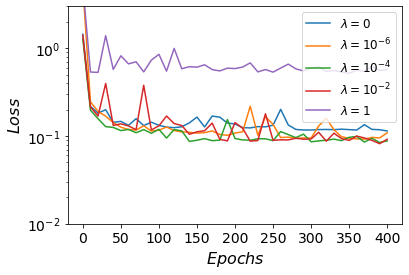

In [143]:
plt.plot(results_wd0['epochs'],results_wd0['val_losses'],label="$\lambda=0$")
plt.plot(results_wd1e6['epochs'],results_wd1e6['val_losses'],label="$\lambda=10^{-6}$")
plt.plot(results_wd1e4['epochs'],results_wd1e4['val_losses'],label="$\lambda=10^{-4}$")
plt.plot(results_wd1e2['epochs'],results_wd1e2['val_losses'],label="$\lambda=10^{-2}$")
plt.plot(results_wd1e0['epochs'],results_wd1e0['val_losses'],label="$\lambda=1$")
#plt.plot(results_nodes256['epochs'],results_nodes256['val_losses'],label="256 nodes")

#formating
plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_weight_decay.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

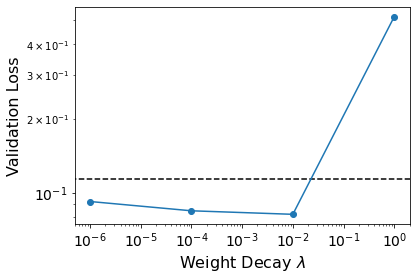

In [151]:
#plt.plot(results_lr005['epochs'],results_lr005['train_losses'],label="Training Set")
plt.plot([1e-6,1e-4,1e-2,1e0],[results_wd1e6['val_best'],results_wd1e4['val_best'],results_wd1e2['val_best'],results_wd1e0['val_best']])
plt.scatter([1e-6,1e-4,1e-2,1e0],[results_wd1e6['val_best'],results_wd1e4['val_best'],results_wd1e2['val_best'],results_wd1e0['val_best']])
plt.hlines([results_wd0['val_best']],[1e-7],[1e1],color='k',linestyles='dashed')
#plt.plot(results_lr005['epochs'],results_lr005['val_losses'],label="$\gamma=0.005$")
#plt.plot(results_batch32['epochs'],results_batch32['val_losses'],label="Batch Size = 32")
#plt.plot(results_batch64['epochs'],results_batch64['val_losses'],label="Batch Size = 64")

#formating
plt.xlim([5e-7,2e0])
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Weight Decay $\lambda$',fontsize=16)
plt.ylabel('Validation Loss',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=12)

plt.savefig('val_loss_vs_weight_decay.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [165]:
# Best model:
model_best, results_best = train(training_set,validation_set,
                           max_epochs=1000,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.005,batch_size=64,weight_decay=1e-6,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       2.4733               0.3022               0.095                *
10      0.0466               0.0634               0.07                 *
20      0.027                0.0515               0.075                *
30      0.019                0.0268               0.098                *
40      0.0233               0.03                 0.384                 
50      0.0208               0.0282               0.331                 
60      0.0134               0.0295               0.336                 
70      0.031                0.1254               0.353                 
80      0.0186               0.0332               0.356                 
90      0.0163               0.0275               0.353                 
100     0.0154               0.0333               0.366                 
110     0.0095               0.0218               0.362                *
120     0.0059               0.0198               0.3

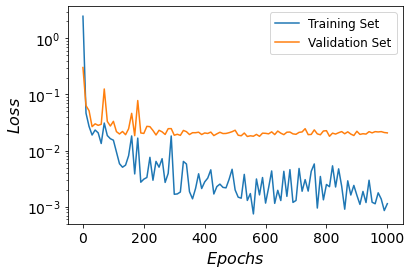

In [167]:
plt.plot(results_best['epochs'],results_best['train_losses'],label="Training Set")
plt.plot(results_best['epochs'],results_best['val_losses'],label="Validation Set")

#formating
#plt.ylim([1e-2,3])
plt.yscale('log')
plt.xlabel('$Epochs$',fontsize=16)
plt.ylabel('$Loss$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.savefig('learning_curve_best1.png',bbox_inches='tight',facecolor='white',edgecolor='white',transparent=False)

plt.show()

In [168]:
# Best model:
model_best2, results_best2 = train(training_set,validation_set,
                           max_epochs=1000,layer_size=256,n_hidden=2,
                           Dropout=False,p_Drop=0.1,BatchNorm=False,
                           learning_rate=0.005,batch_size=64,weight_decay=1e-6,
                           Verbose=True)

Epoch   Training Loss        Validation Loss      Time                
0       2.7508               0.279                0.092                *
10      0.0618               0.061                0.073                *
20      0.0324               0.0364               0.337                *
30      0.0221               0.0443               0.343                 
40      0.0198               0.0418               0.339                 
50      0.0156               0.0268               0.343                *
60      0.017                0.0246               0.346                *
70      0.0165               0.0311               0.361                 
80      0.0373               0.0327               0.379                 
90      0.009                0.0265               0.357                 
100     0.0079               0.0254               0.386                 
110     0.0091               0.0323               0.348                 
120     0.0089               0.0241               0.3